In [71]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
spark = SparkSession.builder.appName("FacebookProject").getOrCreate()

In [72]:
spark

In [3]:
from pyspark.sql.functions import col, count, when, isnull

directory_path_1 = "hdfs:///data/ProjectDatasetFacebookAU/"
df_facebook_1 = spark.read.option("header", True).json(directory_path_1)

In [4]:
df_filtered = df_facebook_1.filter(col("ad_creation_time").between("2023-10-01", "2024-03-21"))

In [107]:
df_sorted = df_filtered.sort("ad_creation_time", ascending=True)

In [98]:
len(df_sorted.columns)

26

In [74]:
df_sorted.printSchema()

root
 |-- ad_creation_time: string (nullable = true)
 |-- ad_creative_bodies: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_body: string (nullable = true)
 |-- ad_creative_link_caption: string (nullable = true)
 |-- ad_creative_link_captions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_description: string (nullable = true)
 |-- ad_creative_link_descriptions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_title: string (nullable = true)
 |-- ad_creative_link_titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_delivery_start_time: string (nullable = true)
 |-- ad_delivery_stop_time: string (nullable = true)
 |-- ad_snapshot_url: string (nullable = true)
 |-- bylines: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- delivery_by_region: array (nullable = true)
 |    |-- element: struct (containsN

### Data Cleaning

**Drop null columns: Columns that all rows contain null values**

In [6]:
# df_sorted.count()

In [67]:
null_counts = df_sorted.select([count(when(isnull(c), c)).alias(c) for c in df_sorted.columns])
df_null_counts = null_counts.toPandas()

24/05/19 13:43:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
# df_null_counts

In [68]:
null_columns = []
for idx, value in enumerate(df_null_counts.values[0]):
    if value == 17475418:
        null_columns.append(idx)
       
selected_columns = [df_sorted.columns[i] for i in null_columns]
print(selected_columns)

['ad_creative_body', 'ad_creative_link_caption', 'ad_creative_link_description', 'ad_creative_link_title']


In [108]:
df_dropped = df_sorted.drop('ad_creative_body', 'ad_creative_link_caption', 
                            'ad_creative_link_description','ad_creative_link_title')

**Fill null values**

In [70]:
df_null_counts = df_dropped.select([count(when(isnull(c), c)).alias(c) for c in df_dropped.columns]).toPandas()
null_not_zero = []
for idx, value in enumerate(df_null_counts.values[0]):
    if value != 0:
        null_not_zero.append(idx)
selected_columns = [df_dropped.columns[i] for i in null_not_zero]
print(selected_columns)

['ad_creative_bodies', 'ad_creative_link_captions', 'ad_creative_link_descriptions', 'ad_creative_link_titles', 'ad_delivery_stop_time', 'bylines', 'currency', 'delivery_by_region', 'demographic_distribution', 'estimated_audience_size', 'funding_entity', 'impressions', 'languages', 'page_name', 'publisher_platforms', 'region_distribution', 'spend']


In [75]:
df_null_counts

,ad_creation_time,ad_creative_bodies,ad_creative_link_captions,ad_creative_link_descriptions,ad_creative_link_titles,ad_delivery_start_time,ad_delivery_stop_time,ad_snapshot_url,bylines,currency,...,estimated_audience_size,funding_entity,id,impressions,languages,page_id,page_name,publisher_platforms,region_distribution,spend
0,0,1258744,731690,9938821,3691481,0,17470648,0,17374814,17374751,...,17374824,17392757,0,17374751,5578198,0,84,20,17417482,17374751


**Drop NA in spend and impression rows**

In [109]:
df_drop = df_dropped.dropna(subset=['spend', 'impressions'])
# df_pandas = df_drop.select('spend','impressions').toPandas()

**Feature selection & Modification**

In [126]:
df_feature = df_drop.select('ad_creation_time','ad_creative_bodies','ad_creative_link_captions','ad_creative_link_descriptions', 'ad_creative_link_titles','delivery_by_region','demographic_distribution', 'estimated_audience_size','page_name','publisher_platforms','region_distribution','impressions','spend').toPandas()

In [127]:
df_feature = df_feature.dropna(subset=['ad_creative_link_descriptions', 'ad_creative_bodies','ad_creative_link_captions','ad_creative_link_titles'])

In [128]:
df_feature = df_feature.reset_index(drop=True)

In [129]:
df_feature

,ad_creation_time,ad_creative_bodies,ad_creative_link_captions,ad_creative_link_descriptions,ad_creative_link_titles,delivery_by_region,demographic_distribution,estimated_audience_size,page_name,publisher_platforms,region_distribution,impressions,spend
0,2023-10-01,[10 reasons to say NO to the Voice],"[riskyvoice.com, riskyvoice.com, riskyvoice.co...",[10 reasons to say NO to the Voice],"[Don't know, say no.]","[(1, Victoria)]","[(65+, unknown, 0.000508), (18-24, male, 0.117...","(100001, 500000)",Senator James Paterson,"[facebook, instagram]","[(1, Victoria)]","(35000, 39999)","(100, 199)"
1,2023-10-01,[10 reasons to say NO to the Voice],"[riskyvoice.com, riskyvoice.com, riskyvoice.co...",[10 reasons to say NO to the Voice],"[Don't know, say no.]","[(1, Victoria)]","[(18-24, unknown, 0.000386), (25-34, female, 0...","(100001, 500000)",Senator James Paterson,"[facebook, instagram]","[(1, Victoria)]","(5000, 5999)","(0, 99)"
2,2023-10-01,"[This voice is legally risky, with unknown con...",[riskyvoice.com],"[Labor's Voice is legally risky, with unknown ...","[Don't know, say no.]","[(1, Victoria)]","[(65+, unknown, 0.001313), (45-54, male, 0.066...","(100001, 500000)",Senator James Paterson,"[facebook, instagram]","[(1, Victoria)]","(2000, 2999)","(0, 99)"
3,2023-10-01,"[After rapid growth in 2021, NFTs are now larg...",[smartcompany.com.au],[The two most traded sets of NFTs are the Bore...,[A majority of NFTs now estimated to be worthl...,None,None,"(500001, 1000000)",SmartCompany,"[facebook, instagram]",None,"(0, 999)","(0, 99)"
4,2023-10-01,[Time is running out until the tipping point o...,[fb.me],[Sign and share!],[Time is running out to help halt climate change],"[(0.003322, Unknown), (0.019934, Australian Ca...","[(55-64, unknown, 0.003344), (18-24, female, 0...","(1000001, None)",Greenpeace Australia Pacific,"[facebook, instagram]","[(0.003322, Unknown), (0.019934, Australian Ca...","(0, 999)","(0, 99)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44818,2024-03-20,[🗣️You’re invited to have your say on proposed...,[yoursay.whitehorse.vic.gov.au],[Feedback is open until Sunday 31 March. You’r...,[Road Discontinuance Policy],"[(1, Victoria)]","[(45-54, unknown, 0.007407), (35-44, female, 0...","(100001, 500000)",Whitehorse City Council,"[facebook, instagram]",None,"(0, 999)","(0, 99)"
44819,2024-03-20,['बल्ल काम अनुसारको तलब आएको जस्तो लागेको छ।'\...,[sbs.com.au],[फेयर वर्क कमिसनले केही स्याहार कर्मचारीहरूको ...,[अस्ट्रेलियाको एज्ड केयरमा काम गर्नेहरूको तलब ...,"[(0.047962, Australian Capital Territory), (0....","[(45-54, unknown, 0.001188), (35-44, unknown, ...","(50001, 100000)",SBS Nepali,[facebook],None,"(0, 999)","(0, 99)"
44820,2024-03-20,[यो फिल्ममा तपाईँले पो 'रोल' पाउने हो कि? अस्ट...,[sbs.com.au],[लामो समय देखि अस्ट्रेलिया र नेपालको फिल्म क्ष...,[अस्ट्रेलियामा विद्यार्थीका रूपमा आएका नेपाली ...,"[(0.042411, Australian Capital Territory), (0....","[(65+, unknown, 0.001096), (18-24, female, 0.0...","(50001, 100000)",SBS Nepali,[facebook],None,"(1000, 1999)","(0, 99)"
44821,2024-03-20,[What's the difference between bisexual and pa...,[minus18.org.au],"[Bisexual, pansexual – they're similar, they'r...",[What's the difference between bisexual and pa...,None,None,"(100001, 500000)",Minus18,[facebook],None,"(0, 999)","(0, 99)"


**Impression, Spend, estimated_audience_size**

In [130]:
import pandas as pd
for idx, value in enumerate(df_feature['impressions']):
    if value['upper_bound'] is not None:
        df_feature['impressions'][idx] = ((pd.to_numeric(value['upper_bound']) + pd.to_numeric(value['lower_bound'])) / 2).round()
    else:
        df_feature['impressions'][idx] = pd.to_numeric(value['lower_bound'])

In [131]:
for idx, value in enumerate(df_feature['spend']):
    if value['upper_bound'] is not None:
        df_feature['spend'][idx] = ((pd.to_numeric(value['upper_bound']) + pd.to_numeric(value['lower_bound'])) / 2).round()
    else:
        df_feature['spend'][idx] = pd.to_numeric(value['lower_bound'])

In [132]:
for idx, value in enumerate(df_feature['estimated_audience_size']):
    if value is None:
        df_feature = df_feature.drop(idx)
    elif value['upper_bound'] is None:
        df_feature['estimated_audience_size'][idx] = pd.to_numeric(value['lower_bound'])
    else:
        df_feature['estimated_audience_size'][idx] = ((pd.to_numeric(value['upper_bound']) + pd.to_numeric(value['lower_bound'])) / 2).round()

In [140]:
df_feature[['estimated_audience_size','spend','impressions']]

,estimated_audience_size,spend,impressions
0,300000.0,150.0,37500.0
1,300000.0,50.0,5500.0
2,300000.0,50.0,2500.0
3,750000.0,50.0,500.0
4,1000001,50.0,500.0
...,...,...,...
44818,300000.0,50.0,500.0
44819,75000.0,50.0,500.0
44820,75000.0,50.0,1500.0
44821,300000.0,50.0,500.0


**Region_distribution**

In [133]:
def find_max_region(region_list):
    if region_list:
        return max(region_list, key=lambda x: float(x['percentage']))
    return None

In [ ]:
df_feature['max_region'] = df_feature['region_distribution'].apply(find_max_region)

df_feature['region_with_highest_percentage'] = df_feature['max_region'].apply(lambda x: x['region'] if x else None)
df_feature['rd_highest_percentage'] = df_feature['max_region'].apply(lambda x: x['percentage'] if x else None)

print(df_feature[['region_with_highest_percentage', 'rd_highest_percentage']])

In [ ]:
df_feature[['region_with_highest_percentage', 'rd_highest_percentage']]

In [136]:
df_feature['rd_highest_percentage'] = pd.to_numeric(df_feature['rd_highest_percentage'])
highest_mean = df_feature['rd_highest_percentage'].mean()

In [137]:
df_feature['rd_highest_percentage'] = df_feature['rd_highest_percentage'].fillna(highest_mean)

In [138]:
import numpy as np
df_feature['region_with_highest_percentage'] = np.where(df_feature['region_with_highest_percentage'].isnull(), 
                                                        'Unknown', df_feature['region_with_highest_percentage'])

In [139]:
df_feature[['max_region','region_with_highest_percentage', 'rd_highest_percentage']]

,max_region,region_with_highest_percentage,rd_highest_percentage
0,"(1, Victoria)",Victoria,1.00000
1,"(1, Victoria)",Victoria,1.00000
2,"(1, Victoria)",Victoria,1.00000
3,None,Unknown,0.58310
4,"(0.33887, New South Wales)",New South Wales,0.33887
...,...,...,...
44818,None,Unknown,0.58310
44819,None,Unknown,0.58310
44820,None,Unknown,0.58310
44821,None,Unknown,0.58310


In [ ]:
df_feature['region_with_highest_percentage'].value_counts()

**Demographic_distribution**

In [141]:
df_feature['max_demographic'] = df_feature['demographic_distribution'].apply(find_max_region)

# Extracting the region and percentage into separate columns (optional)
df_feature['age_with_highest_percentage'] = df_feature['max_demographic'].apply(lambda x: x['age'] if x else None)
df_feature['gender_highest_percentage'] = df_feature['max_demographic'].apply(lambda x: x['gender'] if x else None)
df_feature['demo_highest_percentage'] = df_feature['max_demographic'].apply(lambda x: x['percentage'] if x else None)

df_feature['age_with_highest_percentage'] = np.where(df_feature['age_with_highest_percentage'].isnull(), 
                                                        'Unknown', df_feature['age_with_highest_percentage'])

In [142]:
df_feature['gender_highest_percentage'] = np.where(df_feature['gender_highest_percentage'].isnull(), 
                                                        'Unknown', df_feature['gender_highest_percentage'])

In [143]:
df_feature['demo_highest_percentage'] = pd.to_numeric(df_feature['demo_highest_percentage'])
highest_mean = df_feature['demo_highest_percentage'].mean()
df_feature['demo_highest_percentage'] = df_feature['demo_highest_percentage'].fillna(highest_mean)

In [144]:
df_feature[['gender_highest_percentage','age_with_highest_percentage','demo_highest_percentage']]

,gender_highest_percentage,age_with_highest_percentage,demo_highest_percentage
0,male,25-34,0.156245
1,male,25-34,0.146996
2,male,18-24,0.138792
3,Unknown,Unknown,0.274828
4,female,25-34,0.187291
...,...,...,...
44818,male,65+,0.177778
44819,male,35-44,0.214964
44820,male,25-34,0.368421
44821,Unknown,Unknown,0.274828


**Ad_creative_bodies, Ad_creative_link_captions, Ad_creative_link_descriptions, Ad_creative_link_titles**

In [145]:
df_feature['ad_creative_bodies'] = np.where(df_feature['ad_creative_bodies'].isnull(), 
                                                        'Unknown', df_feature['ad_creative_bodies'])

df_feature['ad_creative_link_captions'] = np.where(df_feature['ad_creative_link_captions'].isnull(), 
                                                        'Unknown', df_feature['ad_creative_link_captions'])

df_feature['ad_creative_link_descriptions'] = np.where(df_feature['ad_creative_link_descriptions'].isnull(), 
                                                        'Unknown', df_feature['ad_creative_link_descriptions'])

df_feature['ad_creative_link_titles'] = np.where(df_feature['ad_creative_link_titles'].isnull(), 
                                                        'Unknown', df_feature['ad_creative_link_titles'])

In [146]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = ' '.join(text)
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]  
    return tokens

[nltk_data] Downloading package punkt to /home/s4733160/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/s4733160/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [147]:
df_feature['bodies_processed_text'] = df_feature['ad_creative_bodies'].apply(preprocess_text)

In [148]:
df_feature['descriptions_processed_text'] = df_feature['ad_creative_link_descriptions'].apply(preprocess_text)

In [149]:
df_feature['titles_processed_text'] = df_feature['ad_creative_link_titles'].apply(preprocess_text)

In [150]:
df_feature[['bodies_processed_text','descriptions_processed_text','titles_processed_text']]

,bodies_processed_text,descriptions_processed_text,titles_processed_text
0,"[reasons, say, voice]","[reasons, say, voice]","[know, say]"
1,"[reasons, say, voice]","[reasons, say, voice]","[know, say]"
2,"[voice, legally, risky, unknown, consequences,...","[labor, voice, legally, risky, unknown, conseq...","[know, say]"
3,"[rapid, growth, nfts, largely, worthless, bore...","[two, traded, sets, nfts, bored, apes, collect...","[majority, nfts, estimated, worthless]"
4,"[time, running, tipping, point, irreversible, ...","[sign, share]","[time, running, help, halt, climate, change]"
...,...,...,...
44818,"[invited, say, proposed, updates, road, discon...","[feedback, open, sunday, march, invited, say, ...","[road, discontinuance, policy]"
44819,"[तलब, तलब]",[],[तलब]
44820,"[र, त]","[समय, र, प]",[ट]
44821,"[difference, bisexual, pansexual, question, of...","[bisexual, pansexual, similar, different, tota...","[difference, bisexual, pansexual]"


In [151]:
import re
df_feature['ad_creative_link_captions_str'] = df_feature['ad_creative_link_captions'].apply(lambda x: ', '.join(x))
def clean_urls(captions_str):
    captions_str = re.sub(r'https?://|www\.|/$', '', captions_str)
    unique = set([caption.strip() for caption in captions_str.split(',')])
    return ', '.join(unique)
df_feature['cleaned_captions'] = df_feature['ad_creative_link_captions_str'].apply(clean_urls)

In [153]:
df_feature[['cleaned_captions']]

,cleaned_captions
0,riskyvoice.com
1,riskyvoice.com
2,riskyvoice.com
3,smartcompany.com.au
4,fb.me
...,...
44818,yoursay.whitehorse.vic.gov.au
44819,sbs.com.au
44820,sbs.com.au
44821,minus18.org.au


**Publisher**

In [154]:
df_feature['publisher_platforms_str'] = df_feature['publisher_platforms'].apply(lambda x: ', '.join(x))

In [155]:
df_feature[['publisher_platforms_str']]

,publisher_platforms_str
0,"facebook, instagram"
1,"facebook, instagram"
2,"facebook, instagram"
3,"facebook, instagram"
4,"facebook, instagram"
...,...
44818,"facebook, instagram"
44819,facebook
44820,facebook
44821,facebook


**Page_name**

## Data Exploration

**1. Ad Creation Time VS Impression**

In [156]:
import matplotlib.pyplot as plt

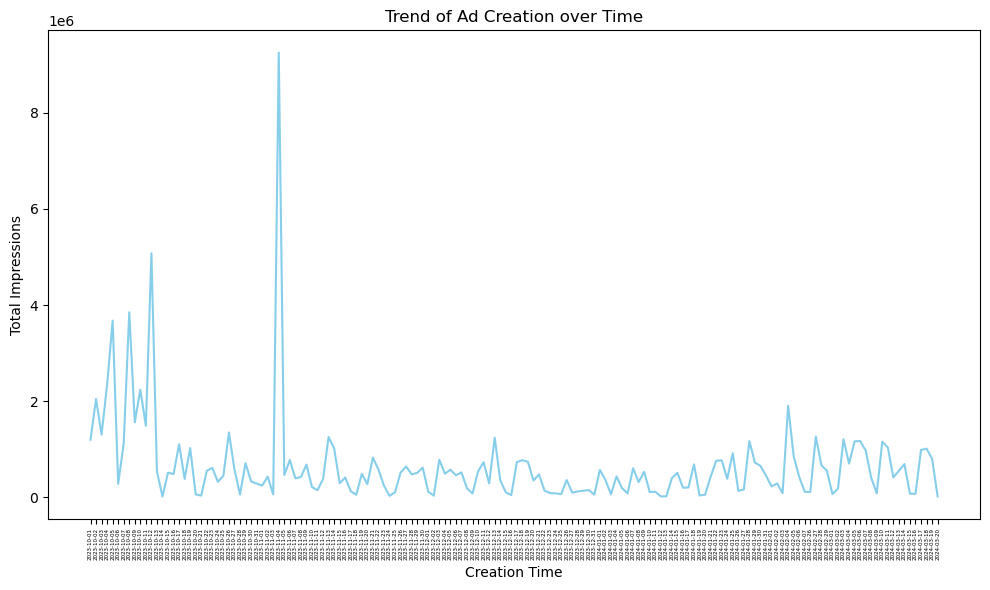

In [38]:
grouped_data = df_feature.groupby('ad_creation_time')['impressions'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(grouped_data['ad_creation_time'], grouped_data['impressions'], color='skyblue')
plt.xlabel('Creation Time')
plt.ylabel('Total Impressions')
plt.title('Trend of Ad Creation over Time')
plt.xticks(rotation=90, fontsize=4)
plt.tight_layout()
plt.show()

**2. Region distribution VS Impression**

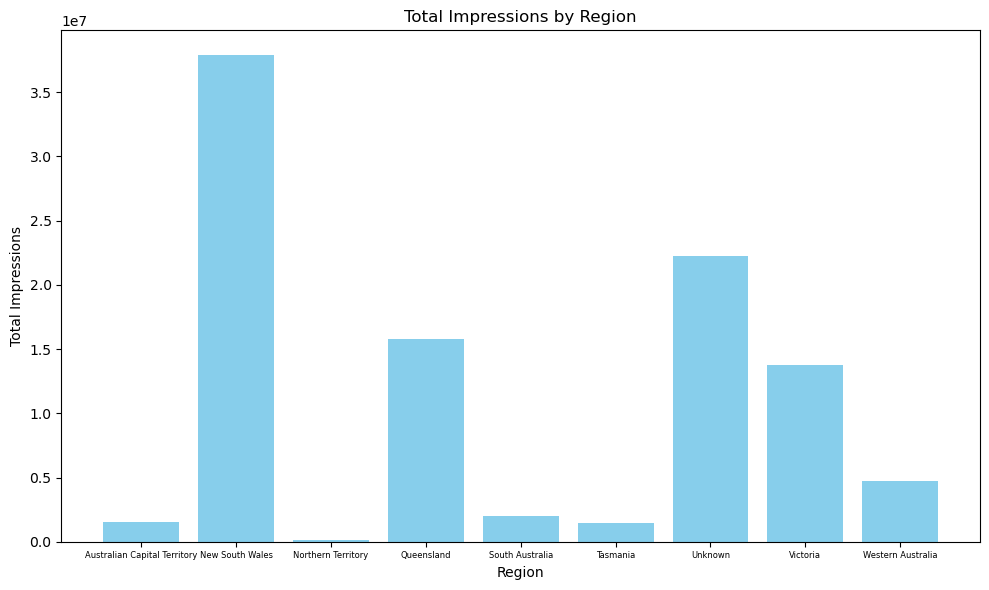

In [39]:
grouped_data = df_feature.groupby('region_with_highest_percentage')['impressions'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(grouped_data['region_with_highest_percentage'], grouped_data['impressions'], color='skyblue')
plt.xlabel('Region')
plt.ylabel('Total Impressions')
plt.title('Total Impressions by Region')
plt.xticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()

**3. Spend VS Impressions**

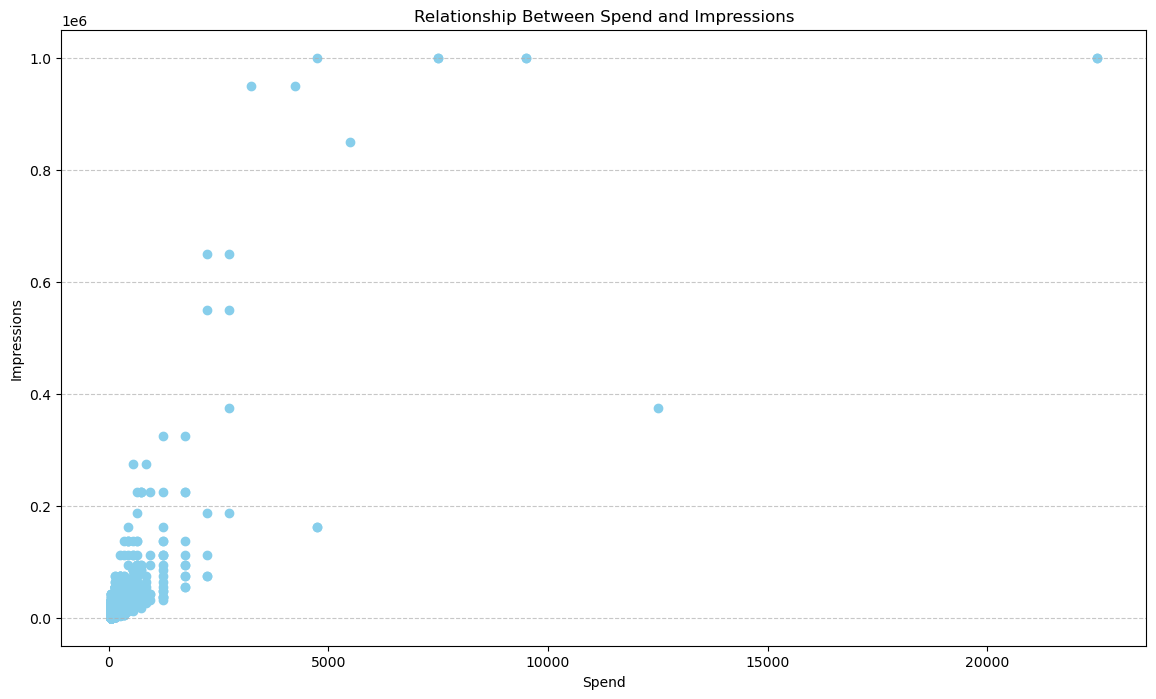

In [40]:
plt.figure(figsize=(14, 8))
plt.scatter(df_feature['spend'], df_feature['impressions'], color='skyblue')
plt.title('Relationship Between Spend and Impressions')
plt.xlabel('Spend')
plt.ylabel('Impressions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**4. Publishers VS Impressions**

In [41]:
df_feature['publisher_platforms'].value_counts()

publisher_platforms
[facebook, instagram]    40334
[facebook]                3303
[instagram]               1149
Name: count, dtype: int64

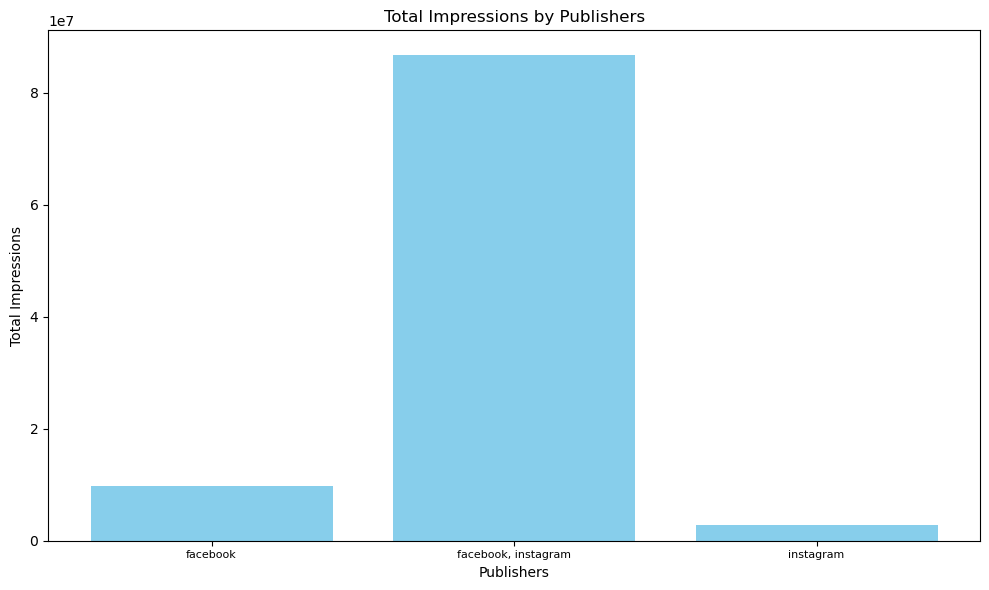

In [42]:
grouped_data = df_feature.groupby('publisher_platforms_str')['impressions'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(grouped_data['publisher_platforms_str'], grouped_data['impressions'], color='skyblue')
plt.xlabel('Publishers')
plt.ylabel('Total Impressions')
plt.title('Total Impressions by Publishers')
plt.xticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

**5. Audience size VS Impressions**

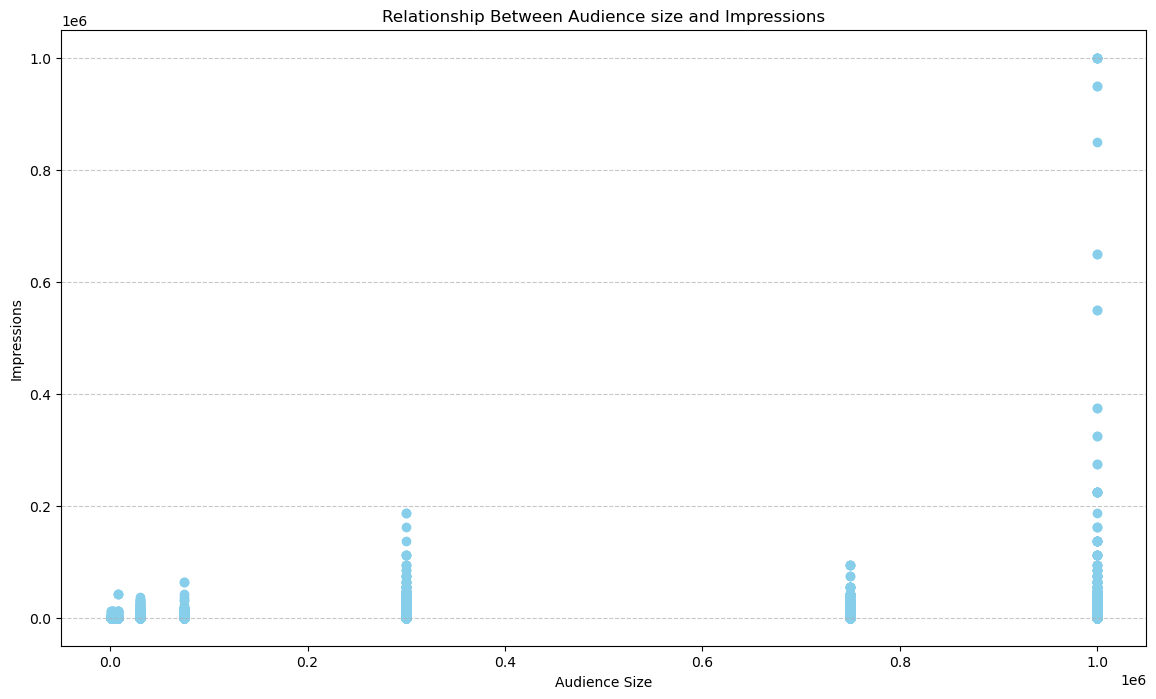

In [43]:
plt.figure(figsize=(14, 8))
plt.scatter(df_feature['estimated_audience_size'], df_feature['impressions'], color='skyblue')
plt.title('Relationship Between Audience size and Impressions')
plt.xlabel('Audience Size')
plt.ylabel('Impressions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**6. Age and Gender VS Impression**

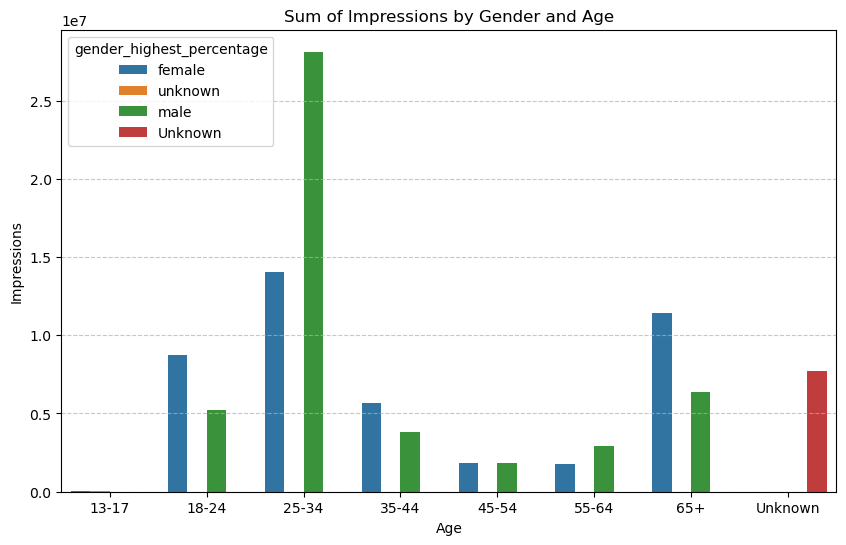

In [44]:
import seaborn as sns
grouped_data = df_feature.groupby(['gender_highest_percentage', 'age_with_highest_percentage'])['impressions'].sum().reset_index()
grouped_data = grouped_data.sort_values(by=['age_with_highest_percentage'])
plt.figure(figsize=(10, 6))
sns.barplot(x='age_with_highest_percentage', y='impressions', hue='gender_highest_percentage', data=grouped_data)
plt.title('Sum of Impressions by Gender and Age')
plt.xlabel('Age')
plt.ylabel('Impressions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**7. Page_name**

/tmp/ipykernel_260330/307777910.py:10: UserWarning: Glyph 24291 (\N{CJK UNIFIED IDEOGRAPH-5EE3}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_260330/307777910.py:10: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_260330/307777910.py:10: UserWarning: Glyph 35441 (\N{CJK UNIFIED IDEOGRAPH-8A71}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_260330/307777910.py:10: UserWarning: Glyph 31680 (\N{CJK UNIFIED IDEOGRAPH-7BC0}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_260330/307777910.py:10: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  plt.tight_layout()
/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24291 (\N{CJK UNIFIED IDEOGRAPH-5EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

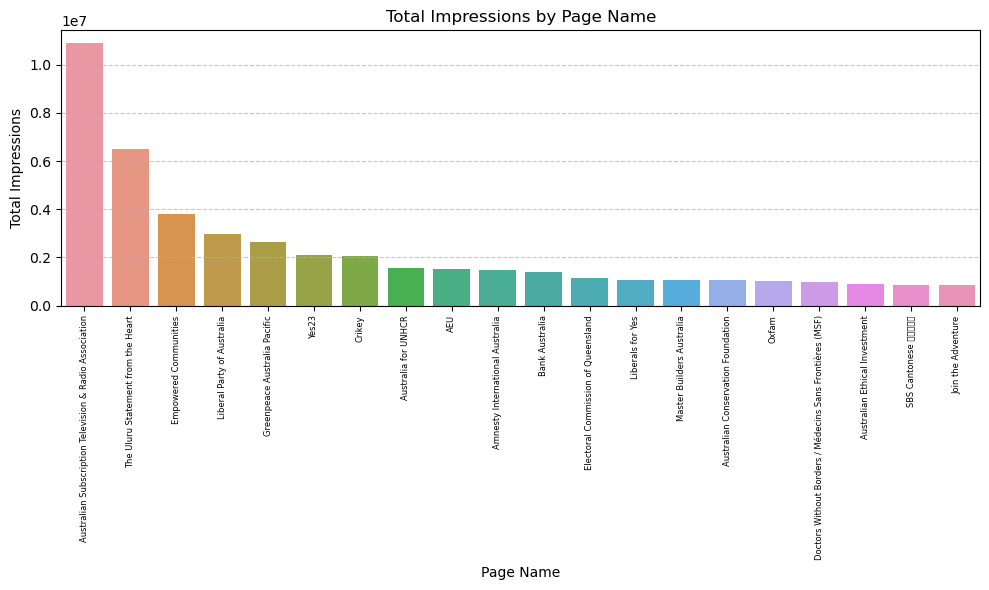

In [45]:
grouped_data = df_feature.groupby('page_name')['impressions'].sum().reset_index()
grouped_data = grouped_data.sort_values(by='impressions', ascending=False)[0:20]
plt.figure(figsize=(10, 6))
sns.barplot(x = 'page_name', y='impressions', data=grouped_data)
plt.xlabel('Page Name')
plt.ylabel('Total Impressions')
plt.title('Total Impressions by Page Name')
plt.xticks(rotation=90, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**8. bodies_processed_text**

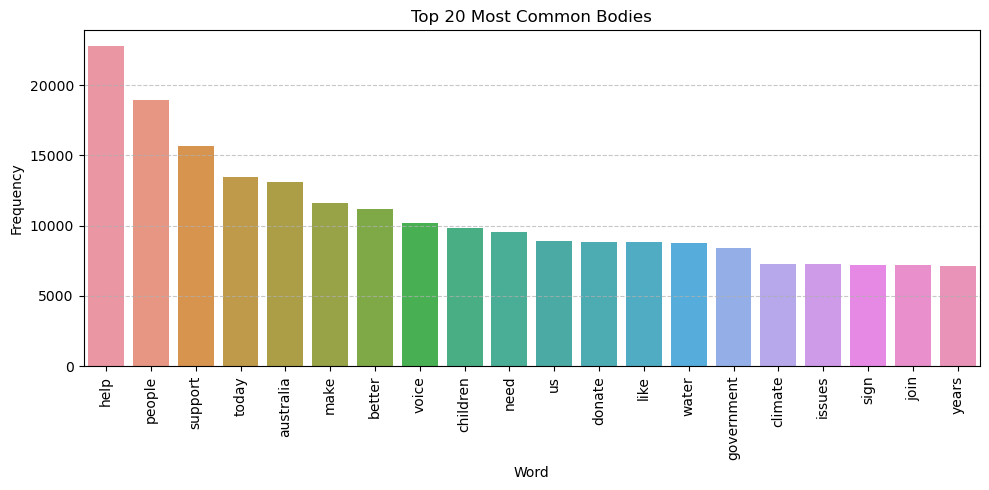

In [46]:
all_words = [word for sublist in df_feature['bodies_processed_text'] for word in sublist]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Word', y='Frequency', data=freq_df)
ax.set_title('Top 20 Most Common Bodies')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
political_keywords = [
    'election', 'government', 'policy', 'vote', 'democracy', 
    'legislation', 'senate', 'congress', 'parliament', 'president', 
    'prime minister', 'diplomacy', 'regulation', 'rights', 'justice', 
    'law', 'reform', 'candidate', 'party', 'campaign', 'debate', 
    'constitution', 'bill', 'state', 'federal', 'civic', 'protest', 
    'movement', 'elections', 'voting', 'political', 'governance', 
    'citizenship', 'activism', 'ideology', 'treaty', 'alliance', 
    'conflict', 'healthcare', 'education', 'taxation'
]

df_feature['bodies_joined'] = df_feature['bodies_processed_text'].apply(' '.join)
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_feature['bodies_joined'])

feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

political_tfidf = tfidf_df[[word for word in political_keywords if word in tfidf_df.columns]]

political_tfidf_sum = political_tfidf.sum(axis=0).sort_values(ascending=False)
grouped_data = df_feature.groupby('page_name')['impressions'].sum().reset_index()
grouped_data = grouped_data.sort_values(by='impressions', ascending=False)[0:20]
plt.figure(figsize=(10, 6))
sns.barplot(x = 'page_name', y='impressions', data=grouped_data)
plt.xlabel('Page Name')
plt.ylabel('Total Impressions')
plt.title('Total Impressions by Page Name')
plt.xticks(rotation=90, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**9. Ad_creative_link_descriptions**

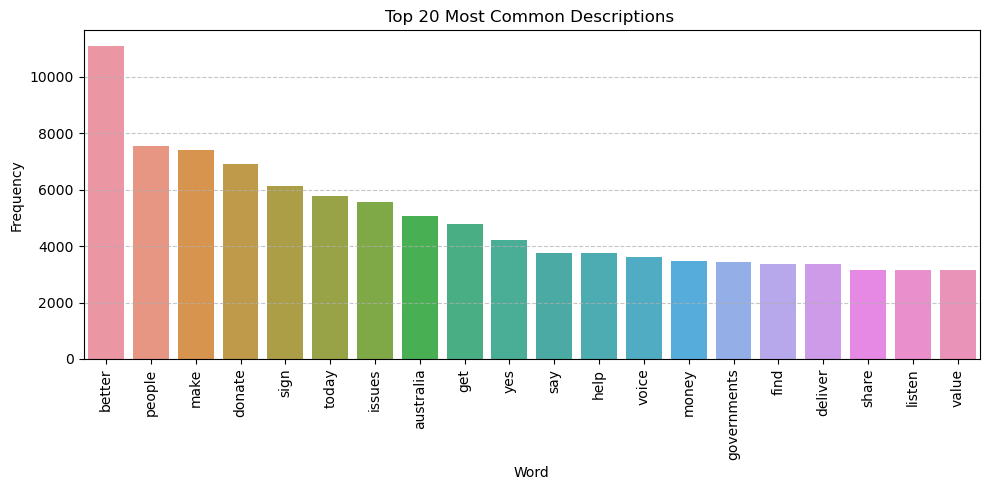

In [48]:
all_words = [word for sublist in df_feature['descriptions_processed_text'] for word in sublist]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Word', y='Frequency', data=freq_df)
ax.set_title('Top 20 Most Common Descriptions ')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [49]:
df_feature['descriptions_joined'] = df_feature['descriptions_processed_text'].apply(' '.join)
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_feature['descriptions_joined'])

feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

tfidf_sum = tfidf_df.sum(axis=0).sort_values(ascending=False)
print(tfidf_sum.head(20))

**9. titles_processed_text**

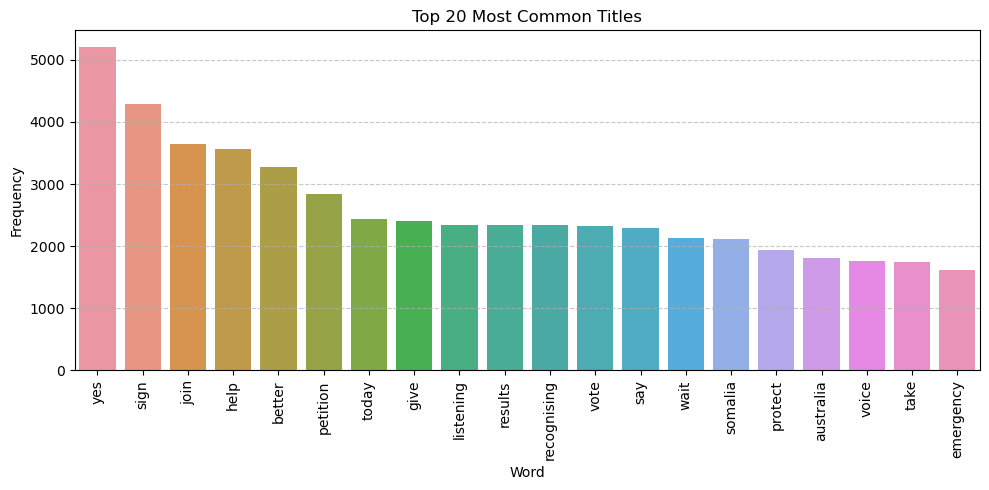

In [50]:
all_words = [word for sublist in df_feature['titles_processed_text'] for word in sublist]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Word', y='Frequency', data=freq_df)
ax.set_title('Top 20 Most Common Titles')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [51]:
df_feature['titles_joined'] = df_feature['titles_processed_text'].apply(' '.join)
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_feature['titles_joined'])

feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

tfidf_sum = tfidf_df.sum(axis=0).sort_values(ascending=False)
print(tfidf_sum.head(20))

In [52]:
df_feature['cleaned_captions'].value_counts().head(20)

cleaned_captions
fb.me                                   3931
crikey.com.au                           1219
smartcompany.com.au                     1213
ref23.au                                1109
bankaust.com.au                         1104
oxfam.org.au/somalia                    1006
yes23.com.au                             989
sbs.com.au                               944
droptheprosecutions.org.au               927
australianethical.com/super              877
amnesty.org.au                           849
yesreasons.au                            821
themandarin.com.au                       817
msf.org.au                               787
smithfamily.com.au/event/giving-tree     740
greenpeace.org.au                        690
defendyourrights.com.au                  600
wateraid.org/au/donate                   597
invasives.org.au                         594
lnp.org.au                               505
Name: count, dtype: int64

In [157]:
grouped_data = df_feature.groupby('cleaned_captions')['impressions'].sum().reset_index()

In [162]:
grouped_data = grouped_data.sort_values('impressions', ascending=False)

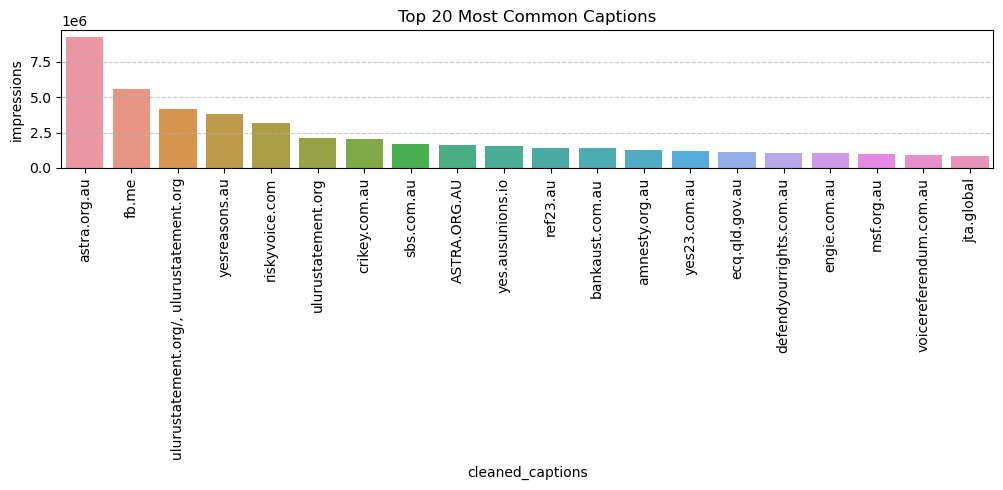

In [163]:
captions_counts = df_feature['cleaned_captions'].value_counts().head(20)

freq_df = pd.DataFrame({'Captions': captions_counts.index,'Frequency': captions_counts.values})

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='cleaned_captions', y='impressions', data=grouped_data[0:20])
ax.set_title('Top 20 Most Common Captions')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Data preparation

In [54]:
df_feature.columns

Index(['ad_creation_time', 'ad_creative_bodies', 'ad_creative_link_captions',
       'ad_creative_link_descriptions', 'ad_creative_link_titles',
       'delivery_by_region', 'demographic_distribution',
       'estimated_audience_size', 'page_name', 'publisher_platforms',
       'region_distribution', 'impressions', 'spend', 'max_region',
       'region_with_highest_percentage', 'rd_highest_percentage',
       'max_demographic', 'age_with_highest_percentage',
       'gender_highest_percentage', 'demo_highest_percentage',
       'bodies_processed_text', 'descriptions_processed_text',
       'titles_processed_text', 'ad_creative_link_captions_str',
       'cleaned_captions', 'publisher_platforms_str', 'bodies_joined',
       'descriptions_joined', 'titles_joined'],
      dtype='object')

In [55]:
df_feature_selected = df_feature[['ad_creation_time', 'estimated_audience_size', 'spend', 'region_with_highest_percentage','age_with_highest_percentage','gender_highest_percentage', 'publisher_platforms_str','page_name','bodies_joined','descriptions_joined','titles_joined','cleaned_captions','impressions']]

In [56]:
df_feature_selected = df_feature_selected.reset_index(drop=True)
X = df_feature_selected[['ad_creation_time', 'estimated_audience_size', 'spend', 'region_with_highest_percentage','age_with_highest_percentage','gender_highest_percentage', 'publisher_platforms_str','page_name','bodies_joined','descriptions_joined','titles_joined','cleaned_captions']]
y = df_feature_selected[['impressions']]

In [62]:
df_feature_selected.to_csv('df_feature_selected.csv', index=False)

**Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

lb_enc = LabelEncoder()
oh_enc = OneHotEncoder()
scaler = StandardScaler()
vectorizer = TfidfVectorizer()

X['estimated_audience_size'] = scaler.fit_transform(X[['estimated_audience_size']])
X['spend'] = scaler.fit_transform(X[['spend']])

X['age_with_highest_percentage'] = lb_enc.fit_transform(X[['age_with_highest_percentage']])

caption_frequencies = X['cleaned_captions'].value_counts(normalize=True)  # normalize=True gives the proportion
X['cleaned_captions_freq'] = X['cleaned_captions'].map(caption_frequencies)

In [ ]:
oh_enc = OneHotEncoder()
columns_to_encode = ['region_with_highest_percentage', 'gender_highest_percentage', 'publisher_platforms_str']
encoded_data = oh_enc.fit_transform(X[columns_to_encode])
new_columns = oh_enc.get_feature_names_out(columns_to_encode)
encoded_data_dense = encoded_data.toarray()
encoded_df = pd.DataFrame(encoded_data_dense, columns=new_columns)
X = X.drop(columns=columns_to_encode)
X = pd.concat([X, encoded_df], axis=1)

In [ ]:
tfidf_matrix = vectorizer.fit_transform(X['bodies_joined'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
X = pd.concat([X.drop(columns=['bodies_joined']), tfidf_df], axis=1)

In [ ]:
tfidf_matrix = vectorizer.fit_transform(X['descriptions_joined'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
X = pd.concat([X.drop(columns=['descriptions_joined']), tfidf_df], axis=1)

In [ ]:
tfidf_matrix = vectorizer.fit_transform(X['titles_joined'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
X = pd.concat([X.drop(columns=['titles_joined']), tfidf_df], axis=1)